# Reference:
https://github.com/rapidsai/cuml/blob/branch-21.12/notebooks/kmeans_demo.ipynb

# K-Means Demo

KMeans is a basic but powerful clustering method which is optimized via Expectation Maximization. It randomly selects K data points in X, and computes which samples are close to these points. For every cluster of points, a mean is computed, and this becomes the new centroid.

cuML’s KMeans supports the scalable KMeans++ intialization method. This method is more stable than randomnly selecting K points.
    
The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or cuda_array_interface-compliant), as well as cuDF DataFrames as the input.

For information about cuDF, refer to the [cuDF documentation](https://docs.rapids.ai/api/cudf/stable).

For additional information on cuML's k-means implementation: https://docs.rapids.ai/api/cuml/stable/api.html#cuml.KMeans.

## Imports

In [1]:
import cudf
import cupy
import matplotlib.pyplot as plt

# cuML
from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs

# sklearn
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score

%matplotlib inline

## Define Parameters

In [2]:
n_samples = 100000
n_features = 2

n_clusters = 5
random_state = 0

## Generate Data

In [3]:
# X, y
device_data, device_labels = make_blobs(n_samples=n_samples,
                                        n_features=n_features,
                                        centers=n_clusters,
                                        random_state=random_state,
                                        cluster_std=0.1)

device_data = cudf.DataFrame(device_data) # X
device_labels = cudf.Series(device_labels) # y

In [4]:
# Copy dataset from GPU memory to host memory.
# This is done to later compare CPU and GPU results.
host_data = device_data.to_pandas() # X (CPU)
host_labels = device_labels.to_pandas() # y (CPU)

## Scikit-learn model

### Fit

In [8]:
%%time
kmeans_sk = skKMeans(init="k-means++",
                     n_clusters=n_clusters,
                     #n_jobs=-1,
                    random_state=random_state)

kmeans_sk.fit(host_data)

CPU times: user 866 ms, sys: 75.8 ms, total: 942 ms
Wall time: 355 ms


KMeans(n_clusters=5, random_state=0)

## cuML Model

### Fit

In [9]:
%%time
kmeans_cuml = cuKMeans(init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=40,
                       random_state=random_state)

kmeans_cuml.fit(device_data)

CPU times: user 153 ms, sys: 32.7 ms, total: 185 ms
Wall time: 421 ms


KMeans()

## Visualize Centroids

Scikit-learn's k-means implementation uses the `k-means++` initialization strategy while cuML's k-means uses `k-means||`. As a result, the exact centroids found may not be exact as the std deviation of the points around the centroids in `make_blobs` is increased.

*Note*: Visualizing the centroids will only work when `n_features = 2` 

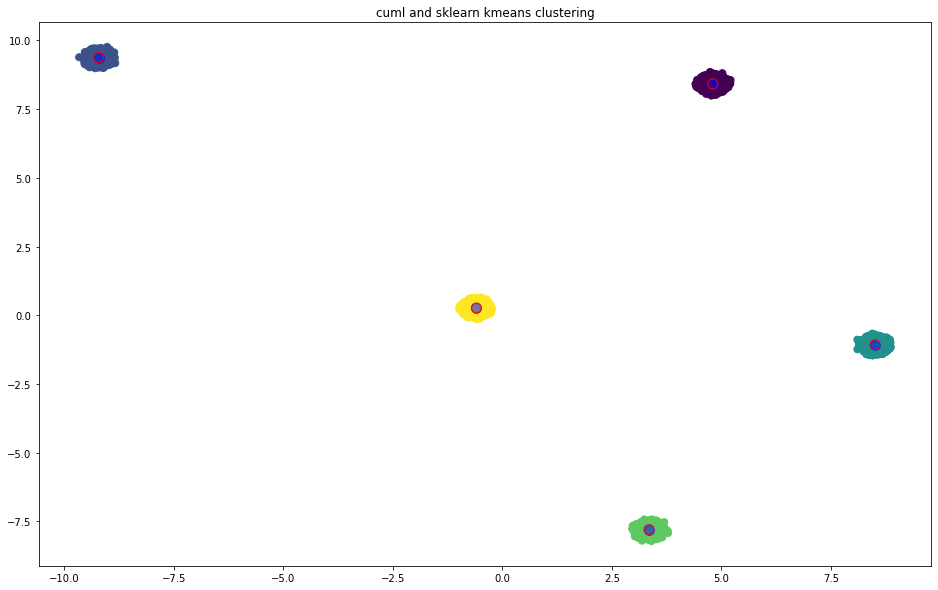

In [10]:
fig = plt.figure(figsize=(16, 10))
# (x-axis, y-axis)
plt.scatter(host_data.iloc[:, 0], host_data.iloc[:, 1], c=host_labels, s=50, cmap='viridis')

#plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], 
            centers_sk[:,1], 
            c='blue', s=100, alpha=.5)

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml[0].values), 
            cupy.asnumpy(centers_cuml[1].values), 
            facecolors = 'none', edgecolors='red', s=100)

plt.title('cuml and sklearn kmeans clustering')

plt.show()

## Compare Results

In [18]:
%%time
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_.to_array())
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)

CPU times: user 35.3 ms, sys: 8.79 ms, total: 44.1 ms
Wall time: 230 ms


In [19]:
threshold = 1e-4

passed = (cuml_score - sk_score) < threshold
print('compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))

compare kmeans: cuml vs sklearn labels_ are equal
